<a href="https://colab.research.google.com/github/rplatkin/benchsmart.ai/blob/main/Decision_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transforms[sentencepiece] evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and

In [ ]:
from datasets import load_dataset
dataset = load_dataset("pasinit/scotus")
train_dataset = dataset["train"]
val_dataset = dataset["validation"]

scotus.py:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/173M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7417 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/914 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/931 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    offset = 100
    sliced_texts = [text[offset:] for text in examples["text"]]
    return tokenizer(sliced_texts, truncation=True, padding="max_length")

tk_train_dataset = train_dataset.map(tokenize_function, batched=True)
tk_val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/7417 [00:00<?, ? examples/s]

Map:   0%|          | 0/914 [00:00<?, ? examples/s]

In [ ]:
# If tokenized_train_dataset is a Hugging Face Dataset
print(f"Number of examples: {len(tk_train_dataset)}, {len(tk_val_dataset)}")

# To see what features (columns) are available
print(f"Features: {tk_train_dataset.features}")
print(f"Features: {tk_val_dataset.features}")


# To check maximum sequence length
max_length = max(len(example['input_ids']) for example in tk_train_dataset)
print(f"Maximum training sequence length: {max_length}")
max_length = max(len(example['input_ids']) for example in tk_val_dataset)
print(f"Maximum test sequence length: {max_length}")

# Get a sample to see what the data looks like
print(f"Sample example: {tk_train_dataset[0]}")
print(tk_train_dataset)
print(f"Sample example: {tk_val_dataset[0]}")
print(tk_val_dataset)

Number of examples: 7417, 914
Features: {'id': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'decisionDirection': Value(dtype='string', id=None), 'respondent': Value(dtype='string', id=None), 'label_ids': Value(dtype='int64', id=None), 'labels': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Features: {'id': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'decisionDirection': Value(dtype='string', id=None), 'respondent': Value(dtype='string', id=None), 'label_ids': Value(dtype='int64', id=None), 'labels': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 

In [ ]:
# First, remove the problematic 'labels' column if it exists
if 'labels' in tk_train_dataset.column_names:
    tk_train_dataset = tk_train_dataset.remove_columns(['labels'])
if 'labels' in tk_val_dataset.column_names:
    tk_val_dataset = tk_val_dataset.remove_columns(['labels'])

# Then rename label_ids to label
if 'label_ids' in tk_train_dataset.column_names:
    tk_train_dataset = tk_train_dataset.rename_column('label_ids', 'label')
if 'label_ids' in tk_val_dataset.column_names:
    tk_val_dataset = tk_val_dataset.rename_column('label_ids', 'label')

# Verify the column structure
print("Final train columns:", tk_train_dataset.column_names)
print("Final val columns:", tk_val_dataset.column_names)

Final train columns: ['id', 'text', 'decisionDirection', 'respondent', 'label', 'input_ids', 'token_type_ids', 'attention_mask']
Final val columns: ['id', 'text', 'decisionDirection', 'respondent', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

In [ ]:
# 1. First, check the unique labels
unique_labels = train_dataset.unique("labels")
num_unique_labels = len(unique_labels)
print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {num_unique_labels}")

Unique labels: ['federalism', 'first_amendment', 'civil_rights', 'criminal_procedure', 'economic_activity', 'unions', 'judicial_power', 'federal_taxation', 'due_process', 'privacy', 'attorneys']
Number of unique labels: 11


In [ ]:
# 2. Create label mapping
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for idx, label in enumerate(unique_labels)}

In [ ]:
print(tk_train_dataset["label"][:5])

[9, 2, 1, 0, 7]


In [ ]:
if "label_ids" in tk_val_dataset.column_names:
    tk_val_dataset = tk_val_dataset.rename_column("label_ids", "label")

In [ ]:
# 4. Load pre-trained model with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_unique_labels,
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 5. Define metrics for evaluation
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {**accuracy, **f1}

In [ ]:
# 6. Set up training arguments
training_args = TrainingArguments(
    output_dir="./scotus_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    push_to_hub=False,  # Set to True if you want to upload to HF Hub
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# 7. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tk_train_dataset,
    eval_dataset=tk_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-16-e83d9c443e00>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#import sys
#sys.exit()

In [ ]:
# 9. Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rplatkin (rplatkin-new-yo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.928435,0.725383,0.694090
2,1.270100,0.704277,0.776805,0.759277
3,0.714500,0.656732,0.798687,0.784693


TrainOutput(global_step=1392, training_loss=0.8581638336181641, metrics={'train_runtime': 1032.2426, 'train_samples_per_second': 21.556, 'train_steps_per_second': 1.349, 'total_flos': 5854957178268672.0, 'train_loss': 0.8581638336181641, 'epoch': 3.0})

In [ ]:
# 10. Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.6567322611808777, 'eval_accuracy': 0.7986870897155361, 'eval_f1': 0.7846928742422535, 'eval_runtime': 13.8607, 'eval_samples_per_second': 65.942, 'eval_steps_per_second': 4.184, 'epoch': 3.0}


In [ ]:
# 11. Save the model
trainer.save_model("./scotus_classifier_final")

Map:   0%|          | 0/931 [00:00<?, ? examples/s]

Test dataset columns: ['id', 'text', 'decisionDirection', 'respondent', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


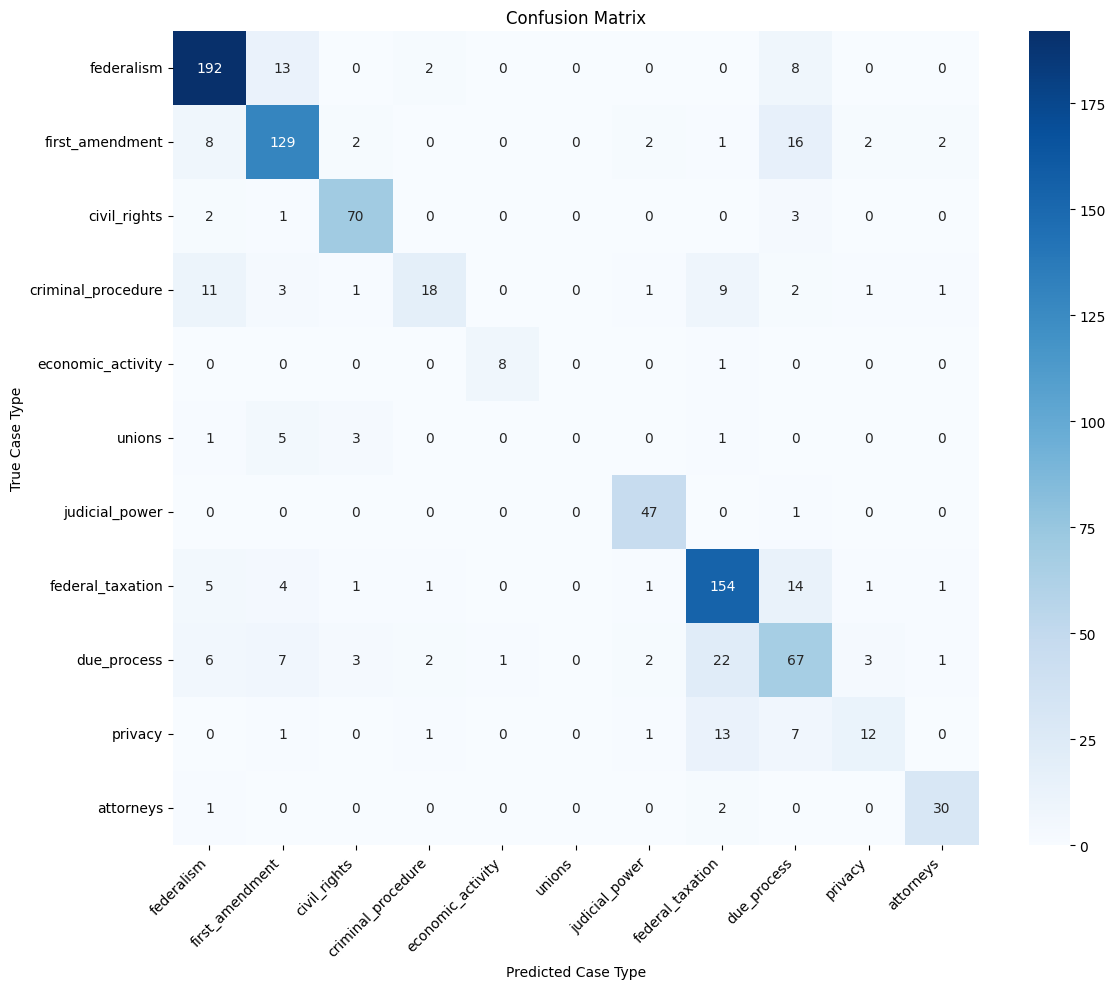

In [ ]:
# Tokenize your third dataset (let's call it test_dataset)

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

test_dataset = dataset["test"]
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Make sure it has the right column name (label instead of labels or label_ids)
if "labels" in tokenized_test.column_names:
    tokenized_test = tokenized_test.remove_columns(["labels"])
if "label_ids" in tokenized_test.column_names:
    tokenized_test = tokenized_test.rename_column("label_ids", "label")

# Verify the columns
print("Test dataset columns:", tokenized_test.column_names)

# Now use the tokenized test dataset for predictions
predictions = trainer.predict(tokenized_test)

# Continue with the confusion matrix code
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get label names
label_names = [id2label[i] for i in range(len(id2label))]

# Create and plot the confusion matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cm_df = pd.DataFrame(cm,
                    index=label_names,
                    columns=label_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Case Type')
plt.xlabel('Predicted Case Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()